# How to use the VAR model for macro fundamentals forecasts

The vector autoregressive VAR(p) model extends the AR(p) model to k series by creating a system of k equations where each contains p lagged values of all k series. The coefficients on the own lags provide information about the dynamics of the series itself, whereas the cross-variable coefficients offer some insight into the interactions across the series.

## Imports and Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import pandas as pd
import pandas_datareader.data as web
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import seaborn as sns

from statsmodels.tsa.api import VARMAX
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import minmax_scale
from scipy.stats import probplot, moment
from sklearn.metrics import mean_absolute_error

In [3]:
sns.set(style='whitegrid',
        context='notebook',
        color_codes=True)

## Helper Functions

### Correlogram Plot

In [4]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title='Time Series')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0], auto_ylims=True)
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1], auto_ylims=True)
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

### Unit Root Test

- Process: Applies Augmented Dickey-Fuller (ADF) test to each column, returning p-values formatted as percentages.
- Purpose: Checks stationarity (p < 0.05 rejects unit root). Markdown notes: "apply the augmented Dickey-Fuller test to verify that the stationarity criterion is met."

In [5]:
def test_unit_root(df):
    return df.apply(lambda x: f'{pd.Series(adfuller(x)).iloc[1]:.2%}').to_frame('p-value')

## Load Data

We will extend the univariate example of a single time series of monthly data on industrial production and add a monthly time series on consumer sentiment, both provided by the Federal Reserve's data service. We will use the familiar pandas-datareader library to retrieve data from 1970 through 2017:

- 'UMCSENT' is consumer sentiment, 'IPGMFN' is industrial production for nondurable manufacturing goods.
- Data spans 1970 to 2019-12, dropping missing values.
- Renames columns for clarity.

In [6]:
sent = 'UMCSENT'
df = web.DataReader(['UMCSENT', 'IPGMFN'], 'fred', '1970', '2019-12').dropna()
df.columns = ['sentiment', 'ip']

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 528 entries, 1972-02-01 to 2019-12-01
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sentiment  528 non-null    float64
 1   ip         528 non-null    float64
dtypes: float64(2)
memory usage: 12.4 KB


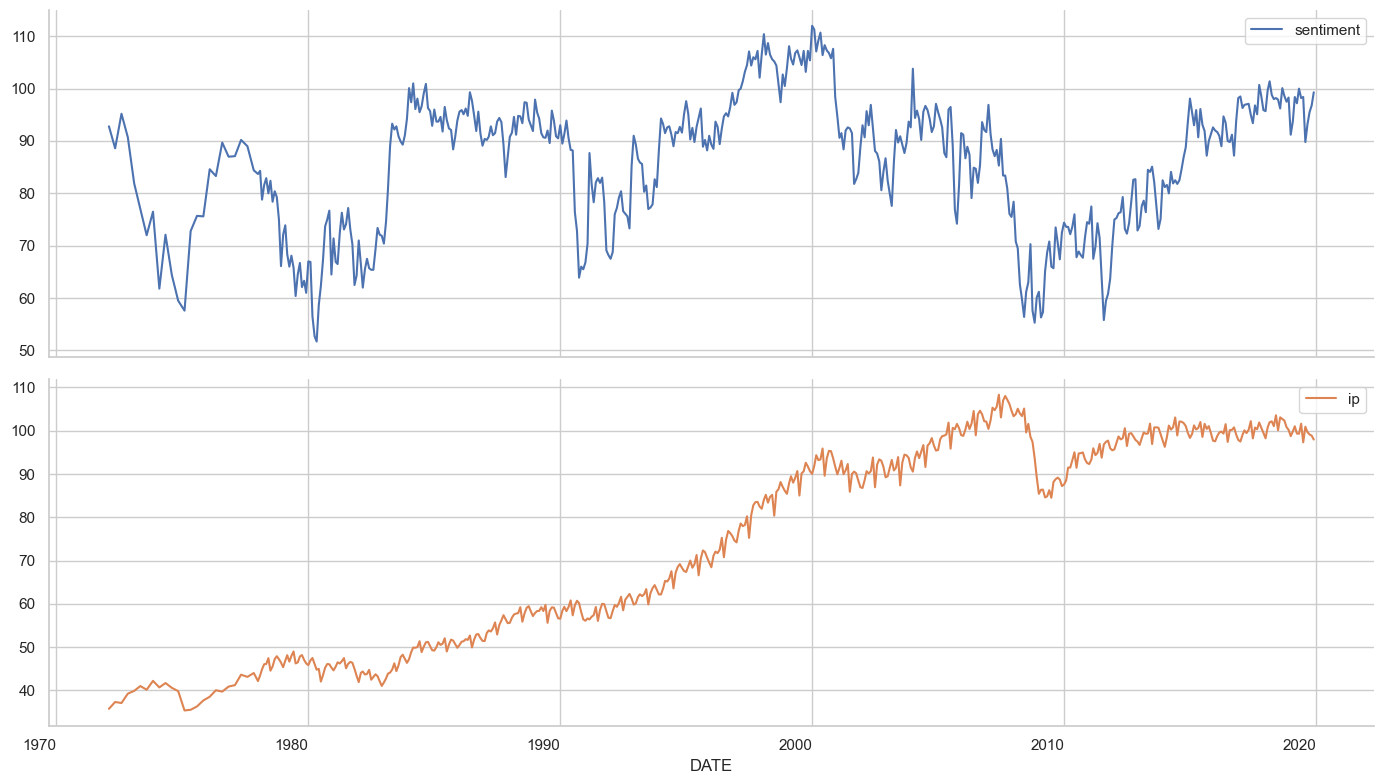

In [8]:
df.plot(subplots=True, figsize=(14,8), rot=0)
sns.despine()
plt.tight_layout();

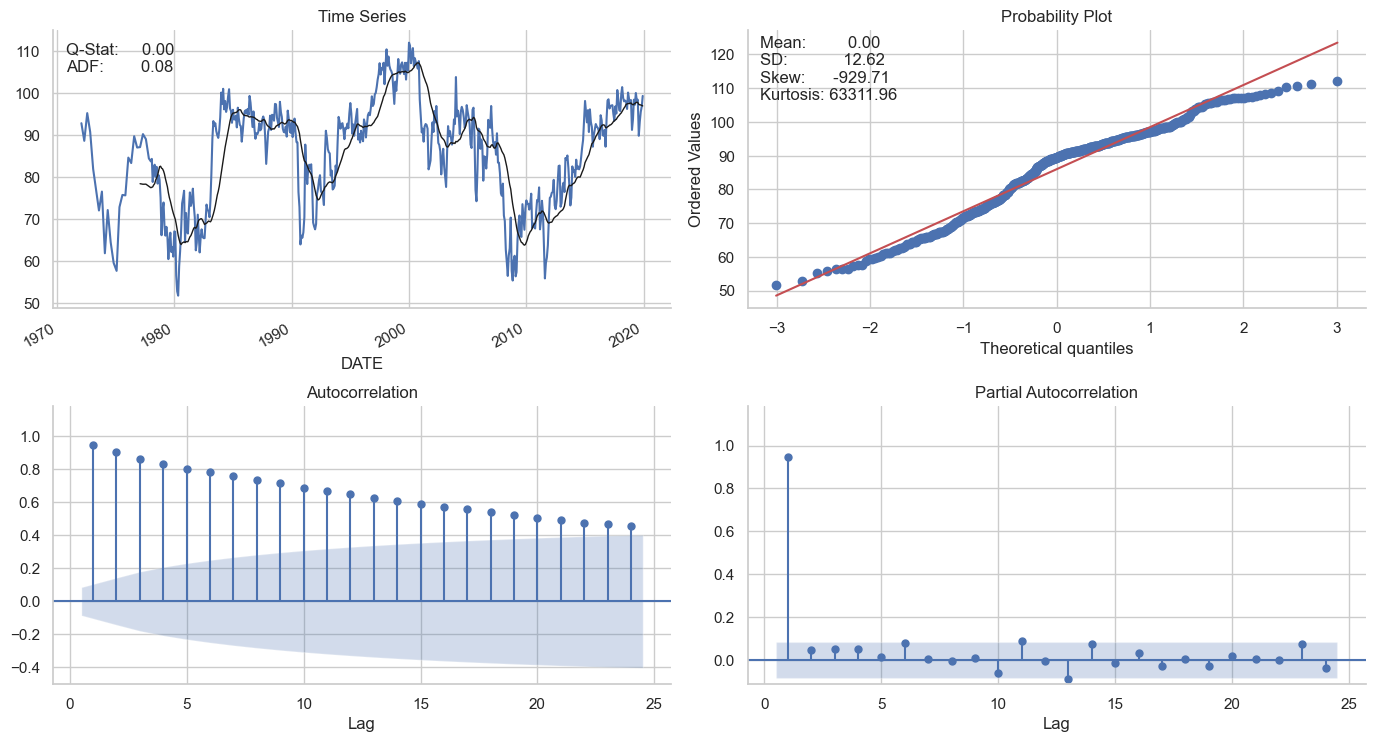

In [9]:
plot_correlogram(df.sentiment, lags=24)

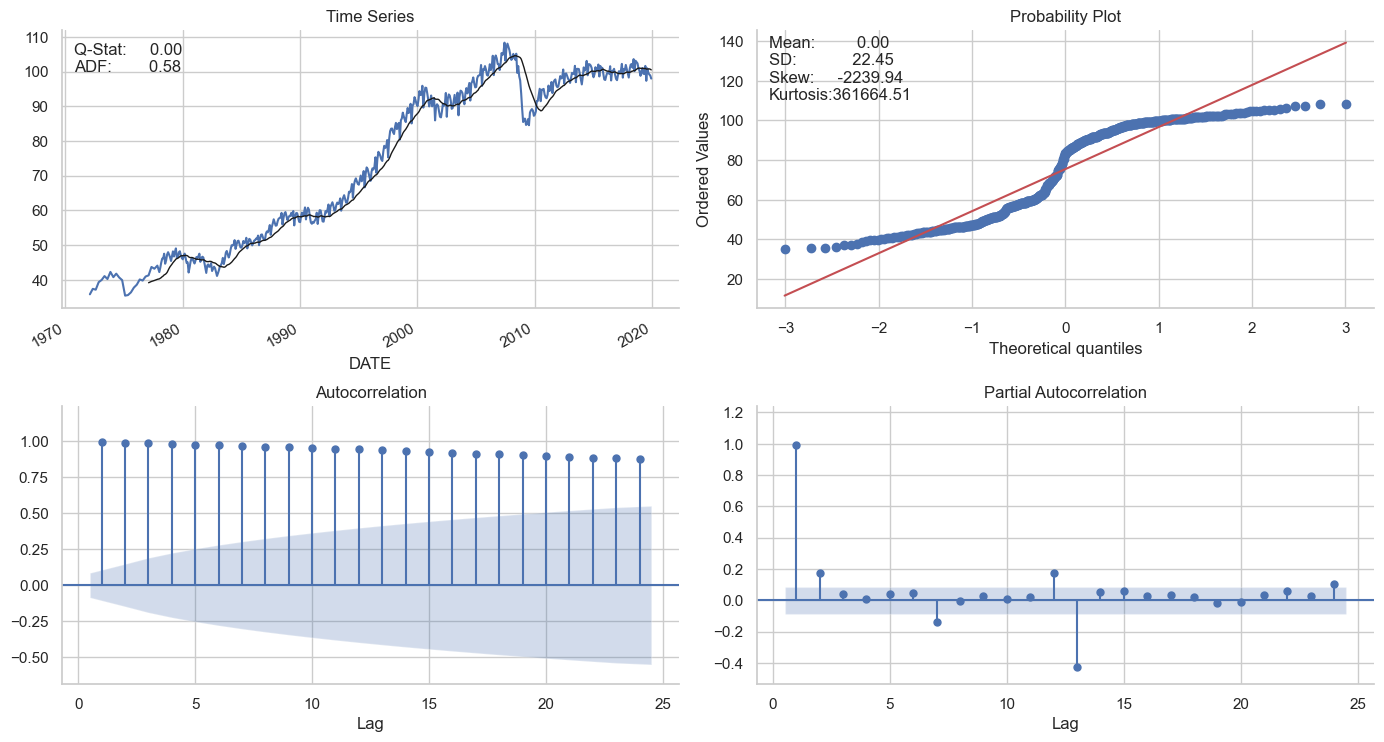

In [10]:
plot_correlogram(df.ip, lags=24)

## Stationarity Transform

Log-transforming the industrial production series and seasonal differencing using lag 12 of both series yields stationary results:

- For industrial production ('ip'): Takes natural log, then differences with lag 12 (seasonal differencing).
- For sentiment: Differences with lag 12.
- Drops NaNs from differencing.

This addresses trends and seasonality.

In [11]:
df_transformed = pd.DataFrame({'ip': np.log(df.ip).diff(12),
                              'sentiment': df.sentiment.diff(12)}).dropna()

## Inspect Correlograms

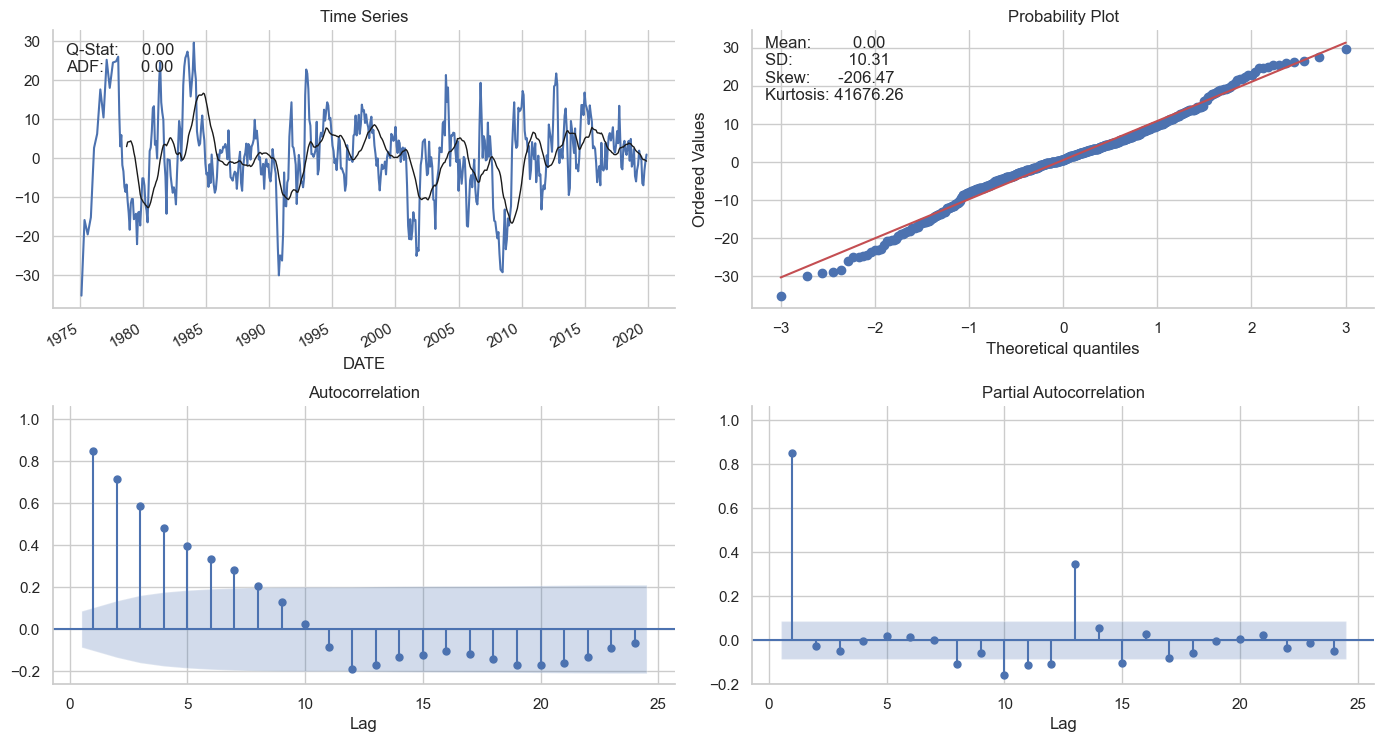

In [12]:
plot_correlogram(df_transformed.sentiment, lags=24)

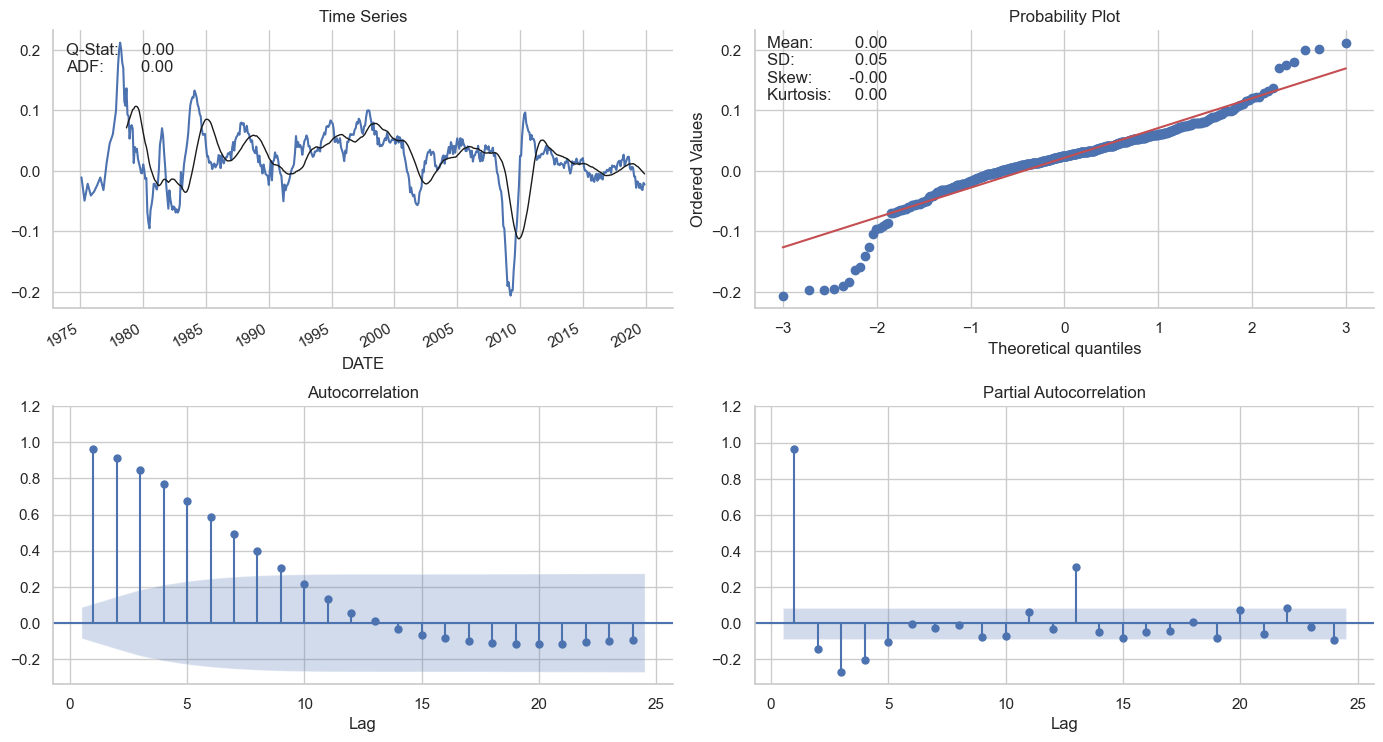

In [13]:
plot_correlogram(df_transformed.ip, lags=24)

In [14]:
test_unit_root(df_transformed)

,p-value
ip,0.02%
sentiment,0.00%


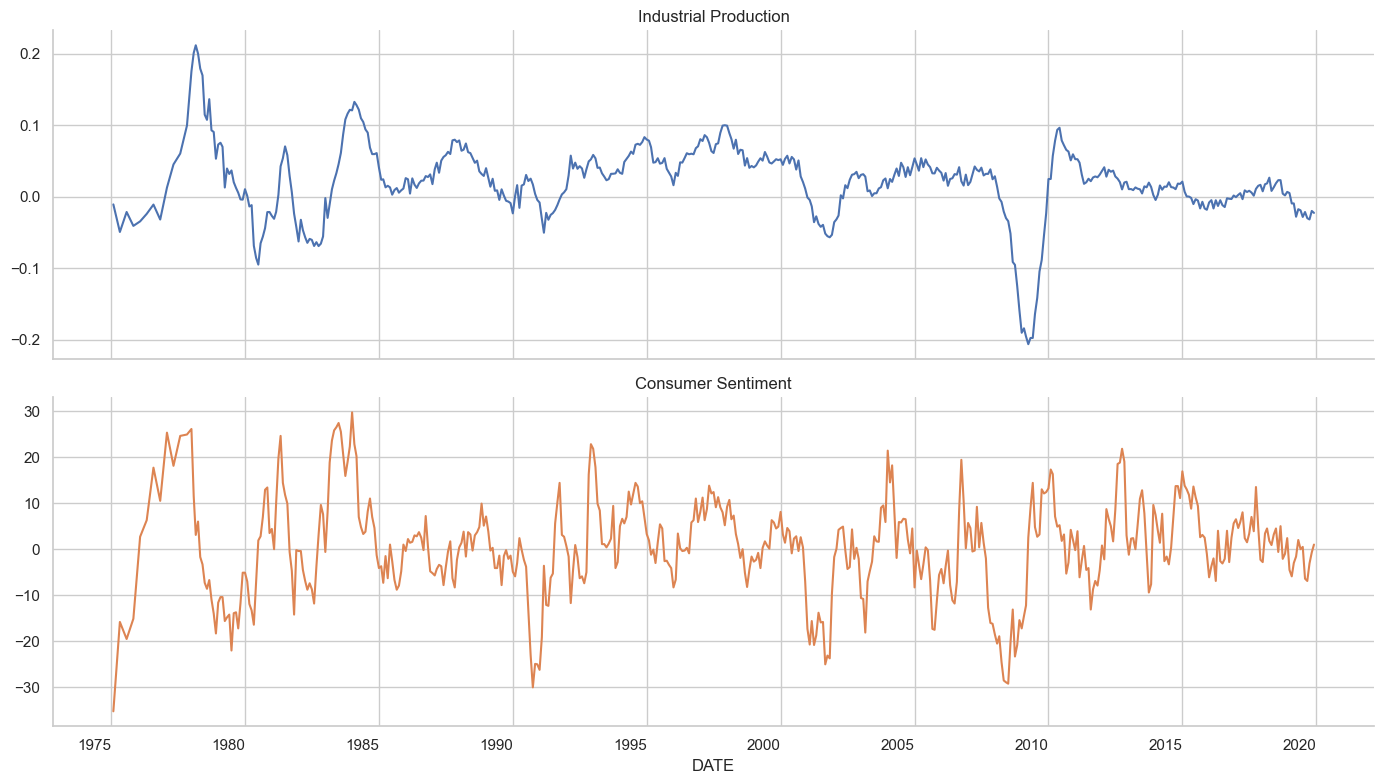

In [15]:
df_transformed.plot(subplots=True, figsize=(14, 8),
                    title=['Industrial Production', 'Consumer Sentiment'],
                    legend=False,
                    rot=0)
sns.despine()
plt.tight_layout()

## VAR Model

To limit the size of the output, we will just estimate a VAR(1) model using the statsmodels VARMAX implementation (which allows for optional exogenous variables) with a constant trend through 2017. The output contains the coefficients for both time series equations.

In [16]:
df_transformed = df_transformed.apply(minmax_scale)
df_transformed

,ip,sentiment
DATE,,
1975-02-01,0.467601,0.000000
1975-05-01,0.375436,0.298921
1975-08-01,0.442287,0.241911
1975-11-01,0.395744,0.309707
1976-02-01,0.410868,0.583975
...,...,...
2019-08-01,0.442147,0.443760
2019-09-01,0.421520,0.436055
2019-10-01,0.417281,0.494607


To limit the size of the output, we will just estimate a VAR(1) model using the statsmodels VARMAX implementation (which allows for optional exogenous variables) with a constant trend using the first 480 observations:

In [17]:
model = VARMAX(df_transformed.loc[:'2017'], order=(1,1), trend='c').fit(maxiter=1000)

/Users/alanwong/miniconda3/envs/crypto/lib/python3.12/site-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/Users/alanwong/miniconda3/envs/crypto/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [18]:
print(model.summary())

                            Statespace Model Results                           
Dep. Variable:     ['ip', 'sentiment']   No. Observations:                  492
Model:                      VARMA(1,1)   Log Likelihood                1558.566
                           + intercept   AIC                          -3091.131
Date:                 Mon, 15 Sep 2025   BIC                          -3036.551
Time:                         16:06:11   HQIC                         -3069.699
Sample:                              0                                         
                                 - 492                                         
Covariance Type:                   opg                                         
Ljung-Box (L1) (Q):             0.15, 0.29   Jarque-Bera (JB):        150.10, 16.69
Prob(Q):                        0.70, 0.59   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.46, 1.03   Skew:                       0.16, 0.20
Prob(H) (two-sided):        

### Plot Diagnostics

`statsmodels` provides diagnostic plots to check whether the residuals meet the white noise assumptions, which are not exactly met in this simple case:

#### Industrial Production

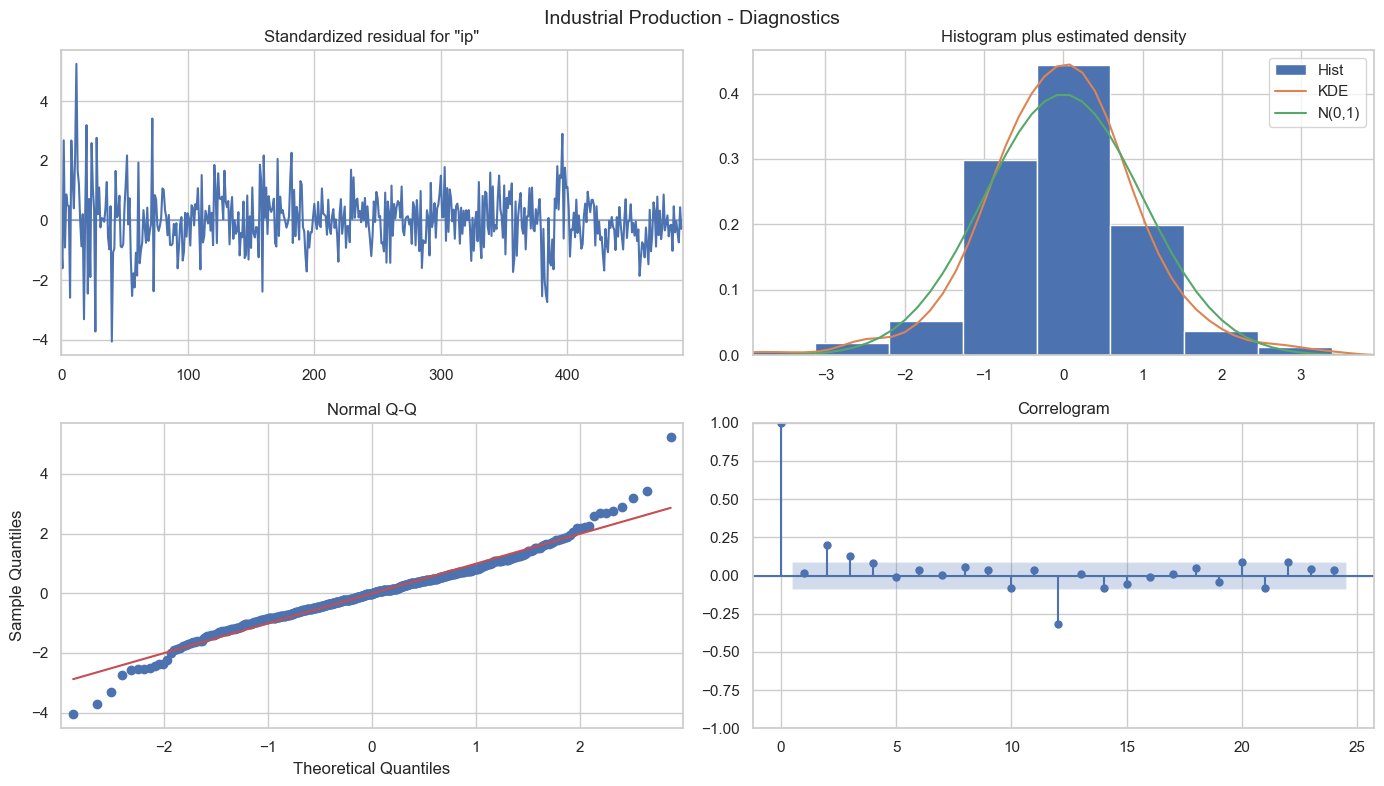

In [19]:
model.plot_diagnostics(variable=0, figsize=(14,8), lags=24)
plt.gcf().suptitle('Industrial Production - Diagnostics', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=.93);

#### Sentiment

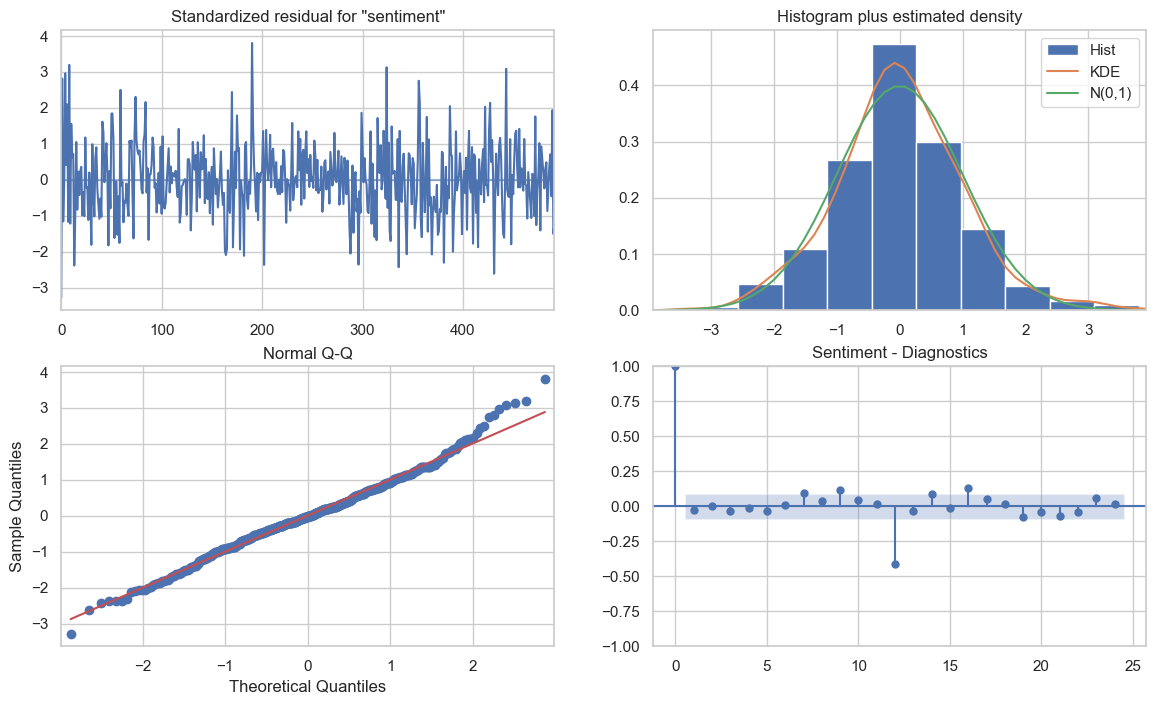

In [20]:
model.plot_diagnostics(variable=1, figsize=(14,8), lags=24)
plt.title('Sentiment - Diagnostics');

In [21]:
model.summary()

Dep. Variable:,"['ip', 'sentiment']",No. Observations:,492
Model:,"VARMA(1,1)",Log Likelihood,1558.566
,+ intercept,AIC,-3091.131
Date:,"Mon, 15 Sep 2025",BIC,-3036.551
Time:,16:06:12,HQIC,-3069.699
Sample:,0,,
,- 492,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.15, 0.29",Jarque-Bera (JB):,"150.10, 16.69"
Prob(Q):,"0.70, 0.59",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"0.46, 1.03",Skew:,"0.16, 0.20"


### Impulse-Response Function

df_transformed: This is the preprocessed DataFrame containing two columns: 'ip' (transformed industrial production) and 'sentiment' (transformed consumer sentiment). The transformations include seasonal differencing (lag 12), a log transformation for 'ip', and min-max scaling to normalize both series to a [0, 1] range. This makes the data stationary and bounded, suitable for modeling.

`.diff()`: Applies first differencing to each column of df_transformed. This calculates the period-to-period changes (e.g., value at time t minus value at time t-1) in the already transformed series. The result is a new DataFrame showing how much each series fluctuates from one observation to the next.

`.quantile(.5)`: Computes the 50th percentile (median) of these differences for each column. **The median is used here as a robust measure of central tendency, less sensitive to outliers than the mean**. This yields a pandas Series with two values: the median change for 'ip' and the median change for 'sentiment'.

`.tolist()`: Converts the Series to a Python list, formatting it as [median_ip_change, median_sentiment_change]. This list serves as the "impulse" input for the model's IRF.

In [22]:
median_change = df_transformed.diff().quantile(.5).tolist()
median_change

[-0.00048066910859978496, -2.220446049250313e-16]

This table shows how the system evolves after the small negative shock to 'ip' (with no meaningful shock to 'sentiment'). The responses are driven by the model's estimated coefficients (autoregressive and moving-average terms), which capture lags and interactions.

- **Step 0 (Immediate Response):**

    - **'ip'**: -0.000481 → Matches the impulse value for 'ip' almost exactly. This is the direct, instantaneous effect: a tiny downward shift in transformed industrial production.
    - 'sentiment': -2.220446e-16 → Essentially zero, matching the impulse. No immediate impact on sentiment.


- **Steps 1–12 (Dynamic Responses):**

    - 'ip' Column: Starts strongly negative and becomes progressively less negative (e.g., from -0.000449 at step 1 to -0.000132 at step 12), approaching zero but remaining negative. This indicates:

        - The shock to 'ip' persists over time due to autoregressive effects (own-lags), but it dampens gradually.
        - By step 12, the effect has faded by about 73% from the initial shock (-0.000481 to -0.000132), suggesting the system is stable and mean-reverting, consistent with stationary data.
        - No sign reversal: The response stays negative, implying no rebound or oscillation in 'ip' from this shock.


    - 'sentiment' Column: Starts near zero, dips slightly negative (e.g., -0.000099 at step 1, -0.000043 at step 2), then turns positive from step 3 onward (e.g., +0.000005 at step 3), increasing to a peak of about +0.000148 at step 11 before a slight dip to +0.000147 at step 12. This indicates:

        - Initial mild negative cross-effect from the 'ip' shock (perhaps a short-term drag on sentiment).
        - Delayed positive response: Sentiment improves over time, stabilizing at a small positive level (around +0.00014 to +0.00015 after step 8).
        - The effect doesn't fully decay to zero by step 12, suggesting longer-term persistence in how 'ip' influences 'sentiment' (cross-variable coefficients in the model).
        - Since the 'sentiment' impulse is zero, these responses are purely from the cross-effects of the 'ip' shock.

**Overall Insights:**

- Magnitude: All values are very small (on the order of 10^-4 or less) because the impulse itself is tiny. If you used a larger impulse (e.g., a unit shock like [1, 0]), responses would scale up proportionally (e.g., multiply by ~1/0.00048 for 'ip' effects).
Direction and Duration: The negative 'ip' shock causes a persistent but fading drag on 'ip' itself, while inducing a biphasic response in 'sentiment' (initial dip, then sustained mild boost). This could imply economic intuition: A small drop in production might briefly lower sentiment but lead to a compensatory positive adjustment over months.
- Model Implications: The fading toward zero (especially for 'ip') confirms the model's stability. Non-zero tails for 'sentiment' might suggest checking for longer steps or model refinements.
Limitations: This is non-orthogonalized (shocks aren't isolated for correlations), non-cumulative (not total effects), and joint (blends both impulses, though 'sentiment' is negligible). For clearer causality, try separate impulses like impulse=[-0.00048, 0] or set orthogonalized=True.

          ip     sentiment
0  -0.000481 -2.220446e-16
1  -0.000449 -9.940164e-05
2  -0.000425 -4.273992e-05
3  -0.000399  4.953327e-06
4  -0.000369  4.436310e-05
5  -0.000338  7.620535e-05
6  -0.000307  1.012088e-04
7  -0.000275  1.200998e-04
8  -0.000244  1.335896e-04
9  -0.000213  1.423639e-04
10 -0.000184  1.470757e-04
11 -0.000157  1.483382e-04
12 -0.000132  1.467216e-04


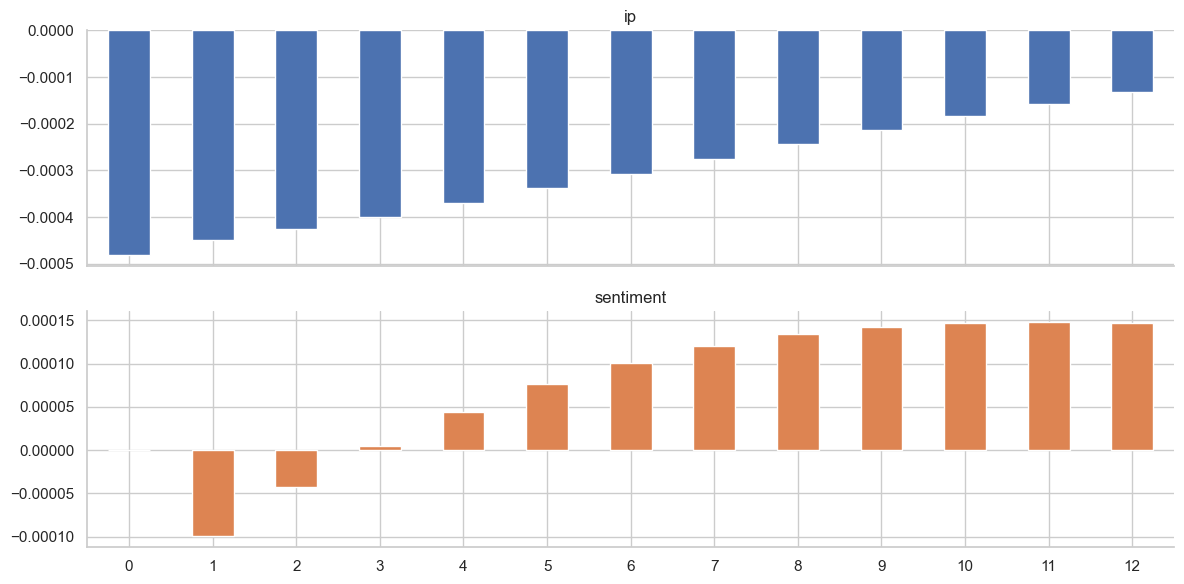

In [23]:
output = model.impulse_responses(steps=12,impulse=median_change,)
print(output)
output.plot.bar(subplots=True,figsize=(12, 6),rot=0,legend=False)
sns.despine()
plt.tight_layout()

### Generate Predictions

Out-of-sample predictions can be generated as follows:

In [24]:
n =len(df_transformed)
start = n-24

preds = model.predict(start=start+1, end=n)

/Users/alanwong/miniconda3/envs/crypto/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


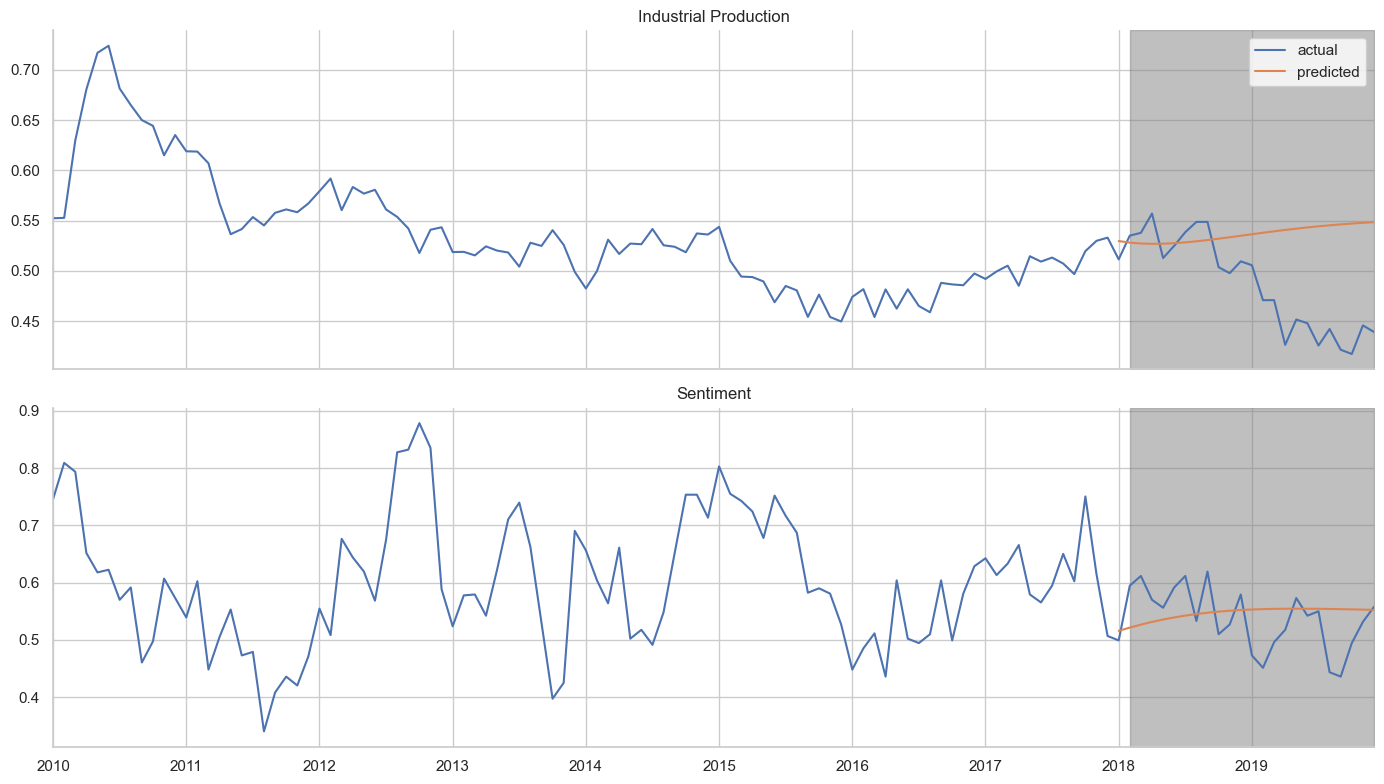

In [25]:
preds.index = df_transformed.index[start:]

fig, axes = plt.subplots(nrows=2, figsize=(14, 8), sharex=True)

df_transformed.ip.loc['2010':].plot(ax=axes[0], label='actual', title='Industrial Production')
preds.ip.plot(label='predicted', ax=axes[0])
trans = mtransforms.blended_transform_factory(axes[0].transData, axes[0].transAxes)
axes[0].legend()
axes[0].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)

trans = mtransforms.blended_transform_factory(axes[0].transData, axes[1].transAxes)
df_transformed.sentiment.loc['2010':].plot(ax=axes[1], label='actual', title='Sentiment')
preds.sentiment.plot(label='predicted', ax=axes[1])
axes[1].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)
axes[1].set_xlabel('')
sns.despine()
fig.tight_layout();

### Out-of-sample forecasts

A visualization of actual and predicted values shows how the prediction lags the actual values and does not capture non-linear out-of-sample patterns well:

In [26]:
forecast = model.forecast(steps=24)

/Users/alanwong/miniconda3/envs/crypto/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


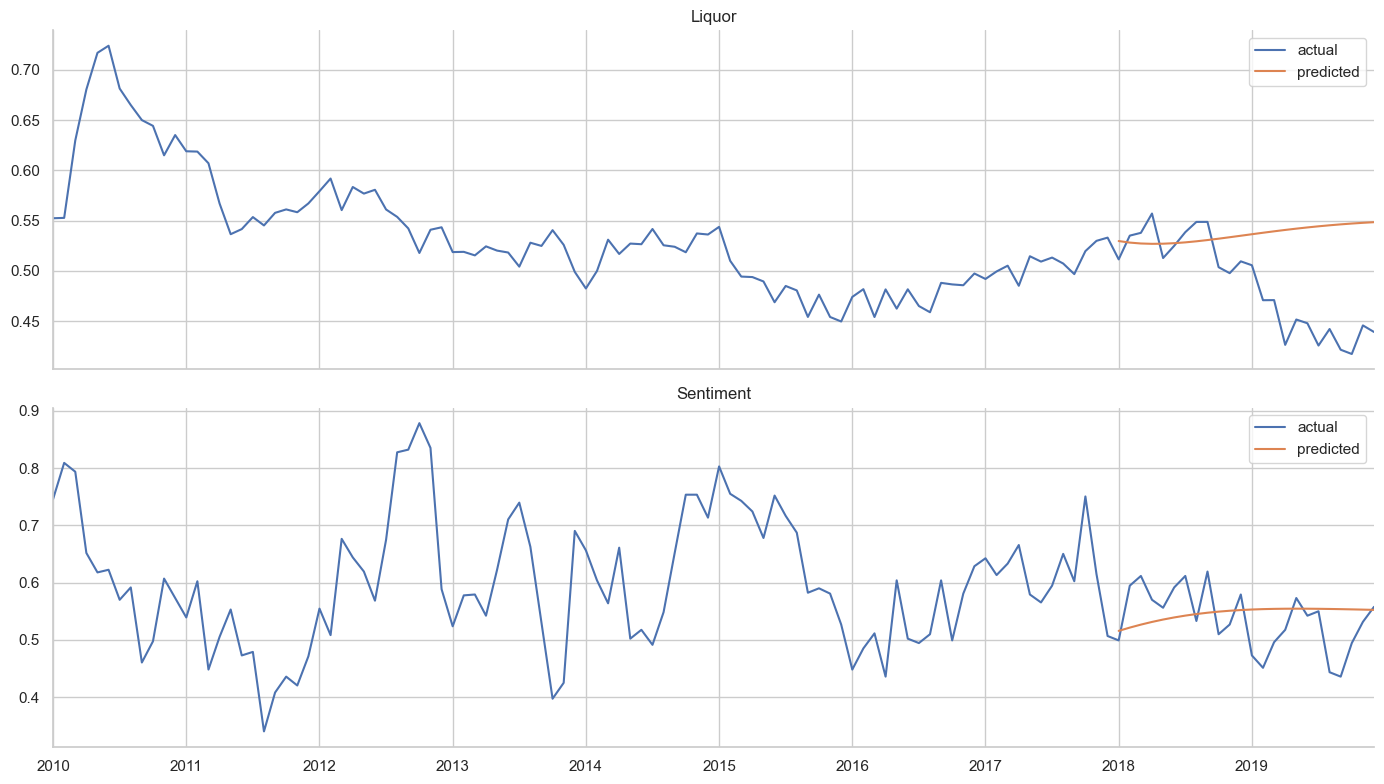

In [27]:
fig, axes = plt.subplots(nrows=2, figsize=(14, 8), sharex=True)

df_transformed['2010':].ip.plot(ax=axes[0], label='actual', title='Liquor')
preds.ip.plot(label='predicted', ax=axes[0])
axes[0].legend()

df_transformed['2010':].sentiment.plot(ax=axes[1], label='actual', title='Sentiment')
preds.sentiment.plot(label='predicted', ax=axes[1])
axes[1].legend()
axes[1].set_xlabel('')
sns.despine()
fig.tight_layout();

In [28]:
mean_absolute_error(forecast, df_transformed.iloc[492:])

0.052740022463354935